In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import math
import scipy.stats as stats
# from scipy.optimize import curve_fit

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import sklearn.preprocessing as prep
import sklearn.metrics as metrics
from sklearn import model_selection

from rfpimp import dropcol_importances
from rfpimp import importances

import pickle

c:\program files\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Helper Functions

#### Helper functions for plotting

In [121]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, 
                     trend_line=False, trend_order=1, trend_color=None, 
                     title='', length_label='', tick_labels='', tick_axis_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        labels = []
        for i, lab in enumerate(bars):
            if bar_labels=='':
                labels.append([f"{j:.4f}" for j in cells[i]])
            else:
                labels.append(bar_labels[i])
#             labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            
            if trend_line:
                trend_color = (color if trend_color is None else trend_color[i])
                _x = np.arange(len(cols))
                _y = cells[i]
                _z = np.polyfit(_x, _y, trend_order)
                _p = np.poly1d(_z)
                trend = ax.plot(_x, _p(_x), color=color, linestyle='--', linewidth=2.5)
            
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        if tick_labels=='':
            ax.set_xticklabels(cols)
        else:
            ax.set_xticklabels(tick_labels)
        if not length_label=='':
            ax.set_ylabel(length_label, fontsize=12, fontweight='bold')
        if not tick_axis_label=='':
            ax.set_xlabel(tick_axis_label, fontsize=12, fontweight='bold')
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            
            if trend_line:
                trend_color = (color if trend_color is None else trend_color[i])
                _x = np.arange(len(cols))
                _y = cells[i]
                _z = np.polyfit(_x, _y, trend_order)
                _p = np.poly1d(_z)
                trend = ax.plot(_x, _p(_x), color=color, linestyle='--', linewidth=2.5)
            
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='v')
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        if tick_labels=='':
            ax.set_yticklabels(cols)
        else:
            ax.set_yticklabels(tick_labels)
        if not length_label=='':
            ax.set_xlabel(length_label, fontsize=12, fontweight='bold')
        if not tick_axis_label=='':
            ax.set_ylabel(tick_axis_label, fontsize=12, fontweight='bold')
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title, fontsize=14, fontweight='bold')
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
        
    ax.grid(True, axis='y')

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True, annotate=False, annot_kwargs=8):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=annotate,
                annot_kws={'size': annot_kwargs})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None, xticklabels=None, yticklabels=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = np.array([[i for j in range(len(n_classes))] for i in n_classes])
        norm_matrix = conf_matrix / n_matrix
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               n_matrix[i, j]) for j, v in enumerate(norm_matrix[i])] for i, v in enumerate(norm_matrix)])
        _xticklabels=('auto' if xticklabels is None else xticklabels)
        _yticklabels=('auto' if yticklabels is None else yticklabels)
        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues', cbar=False, 
                    xticklabels=_xticklabels, yticklabels=_yticklabels)
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels='auto', yticklabels='auto')

    ax.set_ylabel('True Labels', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Labels', fontsize=12, fontweight='bold')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title, fontsize=14, fontweight='bold')
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values
    
def plot_mae_deciles(model, X, y_true, y_bl, index, ax, log_transform=False, cumulative=False, title=None):
    y_pred = np.exp(model.predict(X)) - 1
    y_true = np.exp(y_true.values) - 1
    y_bl = np.exp(y_bl.values) - 1
    y = np.stack([y_pred, y_true], axis=1)
    y = pd.DataFrame(y, columns=['predicted_y', 'true_y'])

    y['mae_model'] = np.abs(y['true_y'] - y['predicted_y'])
    y['mean_y_baseline'] = np.mean(y_bl)
    y['mae_naive'] = np.abs(y['true_y'] - y['mean_y_baseline'])
    y = y[['mean_y_baseline', 'predicted_y', 'true_y', 'mae_model', 'mae_naive']].sort_values(by='mae_model', ascending=True)
    y['deciles'] = pd.qcut(y['mae_model'], 10, labels=False, duplicates='drop')

    mae_model = []
    mae_naive = []
    dec_labs = y['deciles'].unique()
    ax.set_xticks(np.arange(len(dec_labs)))
    for i in dec_labs:
        if cumulative:
            mae_model.append(np.mean(y.loc[y['deciles']<=i, 'mae_model']))
            mae_naive.append(np.mean(y.loc[y['deciles']<=i, 'mae_naive']))
            ax.set_xticklabels(np.arange(10,110,10))
            ax.set_xlabel('% of population')
            ax.set_ylabel('Mean absolute error \n (cumulative mean)')
        else:
            mae_model.append(np.mean(y.loc[y['deciles']==i, 'mae_model']))
            mae_naive.append(np.mean(y.loc[y['deciles']==i, 'mae_naive']))
            ax.set_xlabel('Deciles')
            ax.set_ylabel('Mean absolute error \n (mean per decile)')
    data = np.stack([mae_model, mae_naive], axis=1)
    data = pd.DataFrame(data, columns=['mae_model', 'mae_naive'])

    _x = data.index
    _y = data['mae_model'].values
    ax.plot(_x, _y, marker='o', color='b')
    
    _y = data['mae_naive']
    ax.plot(_x, _y, marker='o', color='r')
    
    ax.legend(['Model predictions', 'Naive predictions'])
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
        
    if log_transform:
        ax.set_yscale('log')
    
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.05])
                 
    deciles = y['deciles']
    if index is not None:
        deciles.index = index
        
    return data, deciles

def plot_deciles_data(data, figname='', color='dimgrey', plot_type='bar', trend_line=False, trend_order=1, trend_color='dimgrey', cumulative_pop=False, data_labels=False, x_label=None, y_label=None):
    grd = list(data.columns)
    grd_n = len(grd)
    grd_cols_n = 2
    grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

    plt_h = 4
    plt_w = 12
    
    fig_ttl = plt.figure()
    fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
    ax0 = fig_ttl.add_subplot()
    ax0.text(0.5, 0.5, figname, fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax0.axis('off')

    fig = plt.figure()
    fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
    gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

    for idx, col in enumerate(list(data.columns)):
        if data_labels:
            labs = ['{0:.2f}'.format(i) for i in data[col]]
            bar_labels=[labs]
        else:
            bar_labels=None
        
        if cumulative_pop:
            tick_labels = np.arange(10,110,10)
        else:
            tick_labels = list(data.index)
        
        if x_label is not None:
            tick_axis_label = x_label
        else:
            tick_axis_label = ''
        if y_label is not None:
            length_label = y_label
        else:
            length_label = col
        
        if plot_type=='bar':
            plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                             data=data[col].to_frame().T,
                             bar_labels=bar_labels,
                             tick_labels = tick_labels,
                             plots_labels=None,
                             plots_colors=[color],
                             width=0.3,
                             trend_line=trend_line, 
                             trend_order=trend_order, 
                             trend_color=[trend_color],
                             title=None,
                             tick_axis_label=tick_axis_label,
                             length_label=length_label,
                             orient='v',
                             spines={'top': False, 'right': False})
        elif plot_type=='scatter':
            ax=fig.add_subplot(gs[idx])
            _x = tick_labels
            _y = data[col].values
            ax.scatter(_x, _y, marker='o', color=color)
            z = np.polyfit(_x, _y, 2)
            p = np.poly1d(z)
            ax.plot(_x, p(_x), color=color)
            
def plot_cls_ratio_deciles(models, Xs, ys_true, indexes, ax, by_class=1, cumulative=False, title=None, legend=None, colors=None):
    deciles = []
    _legend = []
    for idx, model in enumerate(models):
        y_pred = model.predict(Xs[idx])
        y_prob = model.predict_proba(Xs[idx])
        y_true = ys_true[idx]

        y_byclass = np.stack([y_true, y_pred, y_prob[:,by_class]], axis=1)
        y_byclass = pd.DataFrame(y_byclass, index=indexes[idx], columns=['true_y', 'predicted_y', 'proba_y']).sort_values(by='proba_y', ascending=False)
        y_dec = np.zeros(len(y_true))
        n = len(y_dec) // 10
        N = 10 * n
        for i in range(0, N, n):
            if i==N:
                y_dec[i:] = i/n
            else:
                y_dec[i:i+n] = i/n
        y_byclass['deciles'] = y_dec
        y_byclass['deciles'] = y_byclass['deciles'].astype('int32')

        dec_labs = y_byclass['deciles'].unique()
        correct_pred_rate_byclass = []
#         correct_pred_rate_othclass = []
        for i in dec_labs:
            dec_samples = (y_byclass.loc[y_byclass['deciles']<=i] if cumulative else y_byclass.loc[y_byclass['deciles']==i])
            n_true_byclass = len(dec_samples.loc[dec_samples['true_y']==by_class])
            n_correct_pred_byclass = len(dec_samples.loc[(dec_samples['true_y']==by_class) & (dec_samples['predicted_y']==by_class)])
            correct_pred_rate_byclass.append(n_correct_pred_byclass / n_true_byclass)
            
#             n_true_othclass = len(dec_samples.loc[dec_samples['true_y']!=by_class])
#             n_correct_pred_othclass = len(dec_samples.loc[(dec_samples['true_y']!=by_class) & (dec_samples['predicted_y']!=by_class)])
#             correct_pred_rate_othclass.append(n_correct_pred_othclass / n_true_othclass)
        
        y_othclass = np.stack([y_true, y_pred, y_prob[:,np.abs(by_class-1)]], axis=1)
        y_othclass = pd.DataFrame(y_othclass, index=indexes[idx], columns=['true_y', 'predicted_y', 'proba_y']).sort_values(by='proba_y', ascending=False)
        y_dec = np.zeros(len(y_true))
        n = len(y_dec) // 10
        N = 10 * n
        for i in range(0, N, n):
            if i==N:
                y_dec[i:] = i/n
            else:
                y_dec[i:i+n] = i/n
        y_othclass['deciles'] = y_dec
        y_othclass['deciles'] = y_othclass['deciles'].astype('int32')

        dec_labs = y_othclass['deciles'].unique()
#         correct_pred_rate_byclass = []
        correct_pred_rate_othclass = []
        for i in dec_labs:
            dec_samples = (y_othclass.loc[y_othclass['deciles']<=i] if cumulative else y_othclass.loc[y_othclass['deciles']==i])
#             n_true_byclass = len(dec_samples.loc[dec_samples['true_y']==by_class])
#             n_correct_pred_byclass = len(dec_samples.loc[(dec_samples['true_y']==by_class) & (dec_samples['predicted_y']==by_class)])
#             correct_pred_rate_byclass.append(n_correct_pred_byclass / n_true_byclass)
            
            n_true_othclass = len(dec_samples.loc[dec_samples['true_y']!=by_class])
            n_correct_pred_othclass = len(dec_samples.loc[(dec_samples['true_y']!=by_class) & (dec_samples['predicted_y']!=by_class)])
            correct_pred_rate_othclass.append(n_correct_pred_othclass / n_true_othclass)

        _x = np.arange(10)
        _y_byclass = np.array(correct_pred_rate_byclass)
        _y_othclass = np.array(correct_pred_rate_othclass)
        _colors = ([list(mcolors.TABLEAU_COLORS.keys())[idx], 
                    list(mcolors.TABLEAU_COLORS.keys())[len(mcolors.TABLEAU_COLORS.keys())-1-idx]] if colors is None else colors[idx])
        ax.plot(_x, _y_byclass, marker='o', color=_colors[0])
        ax.plot(_x, _y_othclass, marker='o', color=_colors[1])
        
        _legend.append('model {0} target class'.format(idx))
        _legend.append('model {0} other class'.format(idx))
        deciles.append(y_byclass['deciles'])
    
    ax.set_xticks(np.arange(10))
    
    if cumulative:
        ax.set_xticklabels(np.arange(10,110,10))
        ax.set_xlabel('% of population', fontsize=14, fontweight='bold')
        ax.set_ylabel('Correct predictions rate \n (per % of population)', fontsize=12, fontweight='bold')
    else:
        ax.set_xticklabels(np.arange(1,11))
        ax.set_xlabel('Deciles', fontsize=14, fontweight='bold')
        ax.set_ylabel('Correct predictions rate \n (per decile)', fontsize=12, fontweight='bold')
    
    if legend is None:
        legend = _legend
    ax.legend(legend)
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

    if title is None:
        title = model.__class__.__name__
    ax.set_title(title, fontsize=14, fontweight='bold')
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    ax.grid(True)

    return deciles

def plot_diagram_xy(data, x, y, ax, x_title=None, y_title=None, x_labels_format='{0:.0f}', title=None, pot_size=None, tick_labelsIprefix=''):
    _data = data.copy()
    _data = _data.sort_values(by=x, ascending=False)
#     _data['qcut'] = pd.cut(_data[x], 10, labels=False, duplicates='drop')
    _dec = np.zeros(len(_data[x]))
    n = len(_data[x]) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            _dec[i:] = i/n
        else:
            _dec[i:i+n] = i/n
    _data['deciles'] = _dec
    _data['deciles'] = _data['deciles'].astype('int32')

#     cuts = _data['qcut'].unique()
#     _x = np.zeros(len(cuts))
#     _y = np.zeros(len(cuts))
#     for idx, i in enumerate(cuts):
#         _x[len(cuts)-1-idx] = np.mean(_data.loc[_data['qcut']==i, x])
#         _y[len(cuts)-1-idx] = np.mean(_data.loc[_data['qcut']==i, y])
    cuts = _data['deciles'].unique()
    _x = np.zeros(len(cuts))
    _y = np.zeros(len(cuts))
    for idx, i in enumerate(cuts):
        _x[len(cuts)-1-idx] = np.mean(_data.loc[_data['deciles']==i, x])
        _y[len(cuts)-1-idx] = np.mean(_data.loc[_data['deciles']==i, y])
    plot_bar_diagram(ax=ax,
                     data=pd.Series(_y).to_frame().T,
                     tick_labels=[tick_labelsIprefix + x_labels_format.format(i) for i in _x],
                     bar_labels=None,
                     orient='v',
                     width=0.3,
                     title=('{0} vs {1}'.format(y,x) if title is None else title),
                     length_label=(y if y_title is None else y_title),
                     tick_axis_label=(x if x_title is None else x_title),
                     plots_colors=['tab:blue'],
                     spines={'top': False, 'right': False})
    
def plot_diagram_deciles(data, y, ax, x_title=None, y_title=None, title=None, pot_size=None):
    _data = data.copy()
    dec_labs = _data['deciles'].unique()
    dec_mean = []
    for i in dec_labs:
        dec_samples = _data.loc[_data['deciles']==i]
        n = len(dec_samples)
        val_mean = np.mean(dec_samples[y])
        dec_mean.append(val_mean)
        
    plot_bar_diagram(ax=ax,
                     data=pd.Series(dec_mean).to_frame().T,
                     tick_labels=[i for i in dec_labs],
                     bar_labels=None,
                     orient='v',
                     width=0.3,
                     title=('{0} vs {1}'.format(y,x) if title is None else title),
                     length_label=(y if y_title is None else y_title),
                     tick_axis_label=('Deciles' if x_title is None else x_title),
                     plots_colors=['tab:blue'],
                     spines={'top': False, 'right': False})
    
def get_lift_chart_proba(model, data, X, by_class=1):
    _data = data.copy()
#     y_pred = model.predict(X)
#     y_prob = model.predict_proba(X)

#     y = np.stack([y_true, y_pred, y_prob[:,by_class]], axis=1)
#     y = pd.DataFrame(y, columns=['true_y', 'predicted_y', 'proba_y']).sort_values(by='proba_y', ascending=False)
#     y['deciles'] = pd.qcut(y['proba_y'], 10, labels=False, duplicates='drop')
#     y['deciles'] = y['deciles'].apply(lambda x: 9-x)
    
#     y_pred = model.predict(X)
    y_pred = model.predict_proba(X)[:,1]
#     y_true = ys_true[idx]

#     y = np.stack([y_true, y_pred, y_prob[:,1]], axis=1)
#     y = pd.DataFrame(y, columns=['true_y', 'predicted_y', 'proba_y']).sort_values(by='proba_y', ascending=False)
    _data['predicted_y'] = y_pred.reshape(-1,1)
    y = _data.sort_values(by='predicted_y', ascending=False)
    y_dec = np.zeros(len(y_pred))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    def p_cum_sum(arr_n, arr_p, pos):
        arr = []
        for i in range(pos + 1):
            arr.append(arr_p[i] * arr_n[i])
        return np.sum(arr)

    dec_labs = y['deciles'].unique()
    total_mean_proba = np.mean(y['predicted_y'])
    n_samples = []
    dec_mean_proba = []
    dec_lift_ovr_mean = []
    n_cum_samples = []
    cum_mean_proba = []
    cum_lift_ovr_mean = []
    for i in dec_labs:
        dec_samples = y.loc[y['deciles']==i]

        n = len(dec_samples)
        p = np.mean(dec_samples['predicted_y'])
        lift_ovr = p / total_mean_proba - 1

        n_samples.append(n)
        dec_mean_proba.append(p)
        dec_lift_ovr_mean.append(lift_ovr)

        n_cum = len(y.loc[y['deciles']<=i])
        p_cum = (p if i==0 else p_cum_sum(n_samples, dec_mean_proba, i) / n_cum)
        lift_ovr_cum = p_cum / total_mean_proba - 1

        n_cum_samples.append(n_cum)
        cum_mean_proba.append(p_cum)
        cum_lift_ovr_mean.append(lift_ovr_cum)
    lift = np.stack([n_samples, dec_mean_proba, dec_lift_ovr_mean, n_cum_samples, cum_mean_proba, cum_lift_ovr_mean], axis=1)
    return y, total_mean_proba, pd.DataFrame(lift, columns=['n_samples', 'dec_mean_proba', 'dec_lift_ovr_mean', 'n_cum_samples', 'cum_mean_proba', 'cum_lift_ovr_mean'])

#### Helper functions for model training

In [3]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring, fit_params=None):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, fit_params=fit_params, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print('CV results \n ===================================================')
    display(cv_res)
    print('\n Best parameters: ', best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

def dropcol_imp_precision_metric(model, X_valid, y_valid, sample_weights):
    y_pred = model.predict(X_valid)
    return metrics.precision_score(y_valid, y_pred, sample_weight=sample_weights)

def dropcol_imp_roc_auc_metric(model, X_valid, y_valid, sample_weights):
    y_pred = model.predict(X_valid)
    return metrics.roc_auc_score(y_valid, y_pred, sample_weight=sample_weights)

#### Load data

In [150]:
data_2018 = pd.read_excel(io='Data/Transaction Data.xlsx',
                     sheet_name='Transactions18',
                     header=0,
                     index_col=0,
                     verbose=1)

Reading sheet Transactions18


In [151]:
data_2019 = pd.read_excel(io='Data/Transaction Data.xlsx',
                     sheet_name='Transactions19',
                     header=0,
                     index_col=0,
                     verbose=1)

Reading sheet Transactions19


#### Drop refresh date column

In [152]:
data_2018 = data_2018.drop(columns=['refresh_date'])

In [153]:
data_2019 = data_2019.drop(columns=['refresh_date'])

#### Add target columns

In [154]:
data_2019.columns = [i + '_target' for i in list(data_2019.columns)]

In [155]:
data_2019 = data_2019.loc[data_2018.index]

In [156]:
data = pd.concat([data_2018, data_2019], axis=1)

#### Deal with NaNs

All data is numeric and and naturaly is equal or more than zero. So will fill nans with zeros.

In [157]:
data = data.fillna(value=0)

#### Drop samples that have negative sales and positive redemptions

In [158]:
# Inspect positive variables
f_pos = ['sales_12M_target',
         'AUM', 
         'sales_curr',         
         'sales_12M',
         'aum_AC_EQUITY',
         'aum_AC_FIXED_INCOME_MUNI',
         'aum_AC_FIXED_INCOME_TAXABLE',
         'aum_AC_MULTIPLE',
         'aum_AC_PHYSICAL_COMMODITY',
         'aum_AC_REAL_ESTATE',
         'aum_AC_TARGET',
         'aum_P_529',
         'aum_P_ETF',
         'aum_P_MF',
         'aum_P_SMA',
         'aum_P_UCITS',
         'aum_P_UIT']

for i in f_pos:
    print(i, len(data.loc[data[i] < 0]))

sales_12M_target 2
AUM 4377
sales_curr 4
sales_12M 7
aum_AC_EQUITY 3871
aum_AC_FIXED_INCOME_MUNI 3276
aum_AC_FIXED_INCOME_TAXABLE 1694
aum_AC_MULTIPLE 1149
aum_AC_PHYSICAL_COMMODITY 90
aum_AC_REAL_ESTATE 3
aum_AC_TARGET 19
aum_P_529 14
aum_P_ETF 5
aum_P_MF 4564
aum_P_SMA 1151
aum_P_UCITS 15
aum_P_UIT 42


In [159]:
# Inspect negative variables
f_neg = ['redemption_curr',
'redemption_12M']

for i in f_neg:
    print(i, len(data.loc[data[i] > 0]))

redemption_curr 3
redemption_12M 4


In [160]:
data = data.loc[(data['sales_12M']>=0) & 
         (data['sales_12M_target']>=0) & 
         (data['sales_curr']>=0) & 
         (data['redemption_curr']<=0) & 
         (data['redemption_12M']<=0)]

#### Reverse redemptions sign

In [161]:
for i in f_neg:
    data[i] = data[i].apply(np.abs)

#### Add delta_sales = sales_12M_2019 - sales_12M_2018

In [162]:
data['delta_sales_12M_18_19'] = (data['sales_12M_target'] - data['sales_12M'])

#### Add net sales data (net_sales = sales - redumptions)

In [163]:
net_cols = {'net_no_of_sales_12M_1': ['no_of_sales_12M_1', 'no_of_Redemption_12M_1'], 
            'net_no_of_sales_12M_10K': ['no_of_sales_12M_10K', 'no_of_Redemption_12M_10K'], 
            'net_no_of_funds_sold_12M_1': ['no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1'], 
            'net_no_of_fund_sales_12M_10K': ['no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K'], 
            'net_no_of_assetclass_sold_12M_1': ['no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1'], 
            'net_no_of_assetclass_sales_12M_10K': ['no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K']}

In [164]:
for net_col in net_cols.keys():
    data[net_col] = data[net_cols[net_col][0]] - data[net_cols[net_col][1]]

In [165]:
data['net_sales_curr'] = data['sales_curr'] - data['redemption_curr']
data['net_sales_12M'] = data['sales_12M'] - data['redemption_12M']

#### Split aum columns into positive and negative columns

In [166]:
aum_cols = []
for i in list(data.columns):
    if 'aum' in i:
        aum_cols.append(i)

In [167]:
for aum_col in aum_cols:
    data['pos_' + aum_col] = data[aum_col].apply(lambda x: x if x >= 0 else 0)
    data['neg_' + aum_col] = data[aum_col].apply(lambda x: np.abs(x) if x < 0 else 0)

In [168]:
data['pos_AUM'] = data['AUM'].apply(lambda x: x if x >= 0 else 0)
data['neg_AUM'] = data['AUM'].apply(lambda x: np.abs(x) if x < 0 else 0)

#### Split net columns into positive and negative columns

In [169]:
for net_col in list(net_cols.keys()) + ['net_sales_curr', 'net_sales_12M']:
    data['pos_' + net_col] = data[net_col].apply(lambda x: x if x >= 0 else 0)
    data['neg_' + net_col] = data[net_col].apply(lambda x: np.abs(x) if x < 0 else 0)

#### Make a copy of data for post-processing

In [170]:
data_raw = data.copy()

#### Apply log-transform to continuous features

In [24]:
# Drop columns that have negative values
data = data.drop(columns=aum_cols)
data = data.drop(columns=['AUM'])
data = data.drop(columns=list(net_cols.keys()) + ['net_sales_curr', 'net_sales_12M'])

In [25]:
for i in ['sales_curr',
          'sales_12M',
          'redemption_curr',
          'redemption_12M',
          'pos_aum_AC_EQUITY',
          'neg_aum_AC_EQUITY',
          'pos_aum_AC_FIXED_INCOME_MUNI',
          'neg_aum_AC_FIXED_INCOME_MUNI',
          'pos_aum_AC_FIXED_INCOME_TAXABLE',
          'neg_aum_AC_FIXED_INCOME_TAXABLE',
          'pos_aum_AC_MONEY',
          'neg_aum_AC_MONEY',
          'pos_aum_AC_MULTIPLE',
          'neg_aum_AC_MULTIPLE',
          'pos_aum_AC_PHYSICAL_COMMODITY',
          'neg_aum_AC_PHYSICAL_COMMODITY',
          'pos_aum_AC_REAL_ESTATE',
          'neg_aum_AC_REAL_ESTATE',
          'pos_aum_AC_TARGET',
          'neg_aum_AC_TARGET',
          'pos_aum_P_529',
          'neg_aum_P_529',
          'pos_aum_P_ALT',
          'neg_aum_P_ALT',
          'pos_aum_P_CEF',
          'neg_aum_P_CEF',
          'pos_aum_P_ETF',
          'neg_aum_P_ETF',
          'pos_aum_P_MF',
          'neg_aum_P_MF',
          'pos_aum_P_SMA',
          'neg_aum_P_SMA',
          'pos_aum_P_UCITS',
          'neg_aum_P_UCITS',
          'pos_aum_P_UIT',
          'neg_aum_P_UIT',
          'pos_net_sales_curr',
          'pos_net_sales_12M',
          'neg_net_sales_curr',
          'neg_net_sales_12M']:
    data[i] = data[i].apply(lambda x: np.log(x+2))

#### Encode target feature

In [26]:
data['new_Fund_added_12M_target'] = data['new_Fund_added_12M_target'].apply(lambda x: 1 if x > 0 else 0)

#### Data summary

In [27]:
data_cols = ['sales_12M_target', 'new_Fund_added_12M_target']

In [28]:
for col in list(data.columns):
    if not col in data_cols:
        data_cols.append(col)

In [29]:
data = data[data_cols]

In [30]:
data_desc = data.describe().T
data_desc

,count,mean,std,min,25%,50%,75%,max
sales_12M_target,9988.0,211519.205077,1.139872e+06,0.000000,0.000000,87.575000,45143.376250,4.867638e+07
new_Fund_added_12M_target,9988.0,0.251502,4.338980e-01,0.000000,0.000000,0.000000,1.000000,1.000000e+00
no_of_sales_12M_1,9988.0,20.049760,9.849246e+01,0.000000,0.000000,0.000000,8.000000,4.395000e+03
no_of_Redemption_12M_1,9988.0,20.966860,1.917042e+02,0.000000,0.000000,1.000000,8.000000,1.215200e+04
no_of_sales_12M_10K,9988.0,2.415098,1.452724e+01,0.000000,0.000000,0.000000,1.000000,9.860000e+02
...,...,...,...,...,...,...,...,...
neg_net_no_of_assetclass_sales_12M_10K,9988.0,0.178815,4.544581e-01,0.000000,0.000000,0.000000,0.000000,4.000000e+00
pos_net_sales_curr,9988.0,1.933027,2.962739e+00,0.693147,0.693147,0.693147,0.693147,1.608138e+01
neg_net_sales_curr,9988.0,2.151050,3.268324e+00,0.693147,0.693147,0.693147,0.693147,1.620685e+01
pos_net_sales_12M,9988.0,3.514470,4.634025e+00,0.693147,0.693147,0.693147,7.771091,1.697736e+01


#### Preselect features

In [31]:
# net_* features
x_net = []
for i in list(data.columns):
    if 'net' in i:
        x_net.append(i)

In [32]:
# aum_* features
x_aum = []
for i in list(data.columns):
    if 'aum' in i:
        x_aum.append(i)

In [33]:
# no_of*  features
x_noof = []
for i in list(data.columns):
    if (('no_of' in i) or ('No_of' in i)) & (i not in x_net):
        x_noof.append(i)

In [34]:
# no_of*  features
x_other = []
for i in list(data.columns):
    if (i not in x_net) & (i not in x_aum) & (i not in x_noof):
        x_other.append(i)

In [35]:
# Select a subset
x_sel1 = x_noof + x_aum + ['sales_curr', 'sales_12M', 'redemption_curr', 'redemption_12M', 'new_Fund_added_12M']
x_sel2 = x_net + x_aum + ['new_Fund_added_12M']

In [36]:
X_presel1 = data[x_sel1]
X_presel2 = data[x_sel2]

#### Check dataset imbalance

In [37]:
target = 'new_Fund_added_12M_target'

In [38]:
class_probs = [len(data.loc[data[target]==0]) / len(data), len(data.loc[data[target]==1]) / len(data)]
print('Class priors:')
print('Class 0 (NO new funds added): {0:.0%}'.format(class_probs[0]))
print('Class 1 (new funds added): {0:.0%}'.format(class_probs[1]))

Class priors:
Class 0 (NO new funds added): 75%
Class 1 (new funds added): 25%


#### Check correlation

In [39]:
def check_target_corr(ds_target, X_presel, p0):
#     ds_target = data[target].values
    corr_check = {}
    p1 = []
    p2 = []
    p3 = []
    for i in list(X_presel.columns):
        ds = X_presel[i].values
        # Point biserial correlation
        _, p = stats.pointbiserialr(ds_target, ds)
        p1.append(p)
        # Kruskal-Wallis H-test 
        _, p = stats.kruskal(ds_target, ds)
        p2.append(p)
    corr_check['point_biserial'] = p1
    corr_check['kruskal'] = p2

    corr_check = pd.DataFrame(corr_check, index=list(X_presel.columns))

    # A variable is considered to have a relationship with the target if p <= 0.05
    corr_check = corr_check.applymap(lambda i: 1 if i <= p0 else 0)
    corr_check['score'] = corr_check.sum(axis=1)

    # Keep only features with the score >= 2
    corr_check_cols = corr_check.loc[corr_check['score'] == 2].index

    return X_presel[corr_check_cols]

In [40]:
X_presel_corr1 = check_target_corr(data[target].values, X_presel1, 0.05)
X_presel_corr2 = check_target_corr(data[target].values, X_presel2, 0.05)

C:\Users\dimam\AppData\Roaming\Python\Python38\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\dimam\AppData\Roaming\Python\Python38\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


#### Check for multicollinearity

In [41]:
def check_multicollinearity(X_presel, vif0):
    X_presel_mcoll = add_constant(X_presel)
    vif = pd.Series([variance_inflation_factor(X_presel_mcoll.values, i) for i in range(X_presel_mcoll.shape[1])], index=X_presel_mcoll.columns)
    _ = vif.pop('const')
    return X_presel[vif.loc[vif < vif0].index]

In [42]:
X_presel_mcoll1 = check_multicollinearity(X_presel_corr1, 5)
X_presel_mcoll2 = check_multicollinearity(X_presel_corr2, 5)

In [43]:
X_presel_mcoll = data[list(set(X_presel_mcoll1.columns) | set(X_presel_mcoll2.columns))]

In [44]:
list(X_presel_mcoll.columns)

['neg_net_no_of_assetclass_sold_12M_1',
 'neg_aum_AC_REAL_ESTATE',
 'pos_net_no_of_assetclass_sold_12M_1',
 'neg_net_no_of_sales_12M_10K',
 'redemption_curr',
 'no_of_sales_12M_10K',
 'pos_aum_AC_PHYSICAL_COMMODITY',
 'pos_aum_P_529',
 'no_of_sales_12M_1',
 'pos_aum_P_CEF',
 'neg_net_no_of_funds_sold_12M_1',
 'pos_aum_P_UIT',
 'pos_net_no_of_sales_12M_10K',
 'pos_net_sales_12M',
 'pos_aum_AC_REAL_ESTATE',
 'pos_net_no_of_assetclass_sales_12M_10K',
 'neg_aum_P_ETF',
 'pos_aum_P_ETF',
 'neg_net_no_of_fund_sales_12M_10K',
 'neg_net_no_of_assetclass_sales_12M_10K',
 'neg_aum_AC_FIXED_INCOME_MUNI',
 'sales_curr',
 'neg_net_sales_12M',
 'pos_aum_AC_FIXED_INCOME_MUNI',
 'pos_aum_AC_TARGET',
 'new_Fund_added_12M',
 'neg_net_sales_curr',
 'pos_net_no_of_fund_sales_12M_10K',
 'no_of_Redemption_12M_10K',
 'pos_aum_AC_EQUITY',
 'pos_net_sales_curr',
 'pos_net_no_of_sales_12M_1',
 'neg_aum_P_UIT',
 'neg_aum_AC_FIXED_INCOME_TAXABLE',
 'pos_net_no_of_funds_sold_12M_1',
 'neg_aum_AC_MULTIPLE',
 'pos_a

#### Anomaly detection

In [45]:
# DBSCAN
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps = 0.8, metric='euclidean', min_samples=500, n_jobs=-1)
res = dbs.fit_predict(X_presel_mcoll)
res = pd.Series(res, index=X_presel_mcoll.index)
dbs_data = res.loc[res!=-1].index
dbs_noise = res.loc[res==-1].index

In [46]:
print(len(dbs_noise), ' outliers detected.')

9325  outliers detected.


In [47]:
X_presel_outl = X_presel_mcoll.loc[dbs_noise]
y_presel_outl = data.loc[dbs_noise, target]

In [48]:
print('Dataset length after outliers filtered: ', len(X_presel_outl))

Dataset length after outliers filtered:  9325


### Split data into train and test sets

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_presel_outl, y_presel_outl, test_size=0.5, random_state=30)

#### Define cross validation strategy

In [50]:
from sklearn.model_selection import RepeatedStratifiedKFold

random_state=30
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)
scoring = {'accuracy': 'accuracy',
           'roc_auc':  'roc_auc'}
refit='roc_auc'

#### Define function for model validation on the test set

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def test_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('\n Validation on the test set \n ============================')
    print('accuracy: ', accuracy_score(y_test, y_pred))
    print('roc_auc: ', roc_auc_score(y_test, y_pred))

#### Initial model

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [53]:
class_probs = [len(y_train.loc[y_train==0]) / len(y_train), len(y_train.loc[y_train==1]) / len(y_train)]
print('Class probabilities:')
print('Class 0: ', class_probs[0])
print('Class 1: ', class_probs[1])

Class probabilities:
Class 0:  0.7737022737022737
Class 1:  0.2262977262977263


In [54]:
sample_weight = y_train.copy().apply(lambda x: class_probs[1] if x==0 else class_probs[0])

In [55]:
gbc = GradientBoostingClassifier(loss='deviance', 
                                criterion='friedman_mse',
                                learning_rate=0.1,
                                n_estimators=100,
                                random_state=random_state)
lr = LogisticRegression(random_state=random_state, max_iter=1000)

base_estimators = [('gbc',gbc), ('lr',lr)]
stack_model = VotingClassifier(estimators=base_estimators, voting='soft', verbose=1, n_jobs=-1)

In [56]:
stack_model = stack_model.fit(X_train, y_train, sample_weight=sample_weight)
print('CV Results \n================================')
display(cv_rep(stack_model, X_train, y_train, cv, scoring, fit_params={'sample_weight':sample_weight}))
test_score(stack_model, X_test, y_test)

CV Results 


,accuracy,roc_auc
mean_train,0.699614,0.791622
std_train,0.005747,0.003644
mean_test,0.660938,0.719954
std_test,0.015517,0.016215



 Validation on the test set 
accuracy:  0.6450782757881193
roc_auc:  0.6553828524744366


In [57]:
pickle.dump(stack_model, open('stack_model_cls_base.mdl', 'wb'))

In [58]:
stack_model = pickle.load(open('stack_model_cls_base.mdl', 'rb'))

#### Features importance

In [59]:
class_probs_test = [len(y_test.loc[y_test==0]) / len(y_test), len(y_test.loc[y_test==1]) / len(y_test)]
print('Class probabilities:')
print('Class 0: ', class_probs_test[0])
print('Class 1: ', class_probs_test[1])

Class probabilities:
Class 0:  0.7617413682178855
Class 1:  0.2382586317821145


In [60]:
sample_weight_test = y_test.apply(lambda x: class_probs_test[1] if x==0 else class_probs_test[0])

In [61]:
feature_importance_premute = importances(stack_model, X_valid=X_test, y_valid=y_test, metric=dropcol_imp_roc_auc_metric, sample_weights=sample_weight_test)
feature_importance = feature_importance_premute.copy()
feature_importance.columns = ['importance']
feature_importance.sort_values(by='importance',ascending=False)

,importance
Feature,
pos_net_sales_12M,0.030561
neg_net_sales_12M,0.026221
new_Fund_added_12M,0.023737
no_of_sales_12M_1,0.018991
neg_net_no_of_funds_sold_12M_1,0.015886
pos_aum_AC_FIXED_INCOME_TAXABLE,0.008581
neg_net_sales_curr,0.007399
neg_net_no_of_fund_sales_12M_10K,0.004784
no_of_Redemption_12M_1,0.002611


In [62]:
feature_importance.to_csv('imp_features_cls.csv')

In [63]:
feature_importance = pd.read_csv('imp_features_cls.csv', index_col=0)

In [64]:
cols_imp_sorted = list(feature_importance.sort_values(by='importance',ascending=False).index) 

In [65]:
important_cols = list(feature_importance.loc[feature_importance['importance'] > 0].index)

In [66]:
important_cols

['pos_net_sales_12M',
 'neg_net_sales_12M',
 'new_Fund_added_12M',
 'no_of_sales_12M_1',
 'neg_net_no_of_funds_sold_12M_1',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'neg_net_sales_curr',
 'neg_net_no_of_fund_sales_12M_10K',
 'no_of_Redemption_12M_1',
 'pos_aum_P_CEF',
 'neg_aum_AC_MULTIPLE',
 'pos_net_no_of_fund_sales_12M_10K',
 'neg_aum_AC_FIXED_INCOME_TAXABLE',
 'neg_aum_AC_FIXED_INCOME_MUNI',
 'no_of_sales_12M_10K',
 'pos_aum_P_SMA',
 'neg_net_no_of_sales_12M_10K',
 'pos_net_no_of_assetclass_sold_12M_1',
 'pos_net_no_of_funds_sold_12M_1',
 'no_of_Redemption_12M_10K',
 'pos_aum_AC_TARGET',
 'pos_aum_AC_REAL_ESTATE',
 'redemption_curr',
 'pos_aum_P_UIT',
 'neg_net_no_of_assetclass_sold_12M_1',
 'pos_aum_AC_MULTIPLE',
 'sales_curr']

In [67]:
X_presel_impcoll = X_presel_mcoll[important_cols]

In [68]:
X_presel_outl1 = X_presel_impcoll.loc[dbs_noise]
y_presel_outl1 = data.loc[dbs_noise, target]

### Split data into train and test sets

In [69]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_presel_outl1, y_presel_outl1, test_size=0.5, random_state=30)

In [70]:
class_probs1 = [len(y_train1.loc[y_train1==0]) / len(y_train1), len(y_train1.loc[y_train1==1]) / len(y_train1)]
print('Class probabilities:')
print('Class 0: ', class_probs1[0])
print('Class 1: ', class_probs1[1])

Class probabilities:
Class 0:  0.7737022737022737
Class 1:  0.2262977262977263


In [71]:
sample_weight1 = y_train1.apply(lambda x: class_probs1[1] if x==0 else class_probs1[0])

In [72]:
gbc1 = GradientBoostingClassifier(loss='deviance', 
                                criterion='friedman_mse',
                                learning_rate=0.1,
                                n_estimators=100,
                                random_state=random_state)
lr1 = LogisticRegression(random_state=random_state, max_iter=1000)

base_estimators1 = [('gbc',gbc1), ('lr',lr1)]
stack_model1 = VotingClassifier(estimators=base_estimators1, voting='soft', verbose=1, n_jobs=-1)

In [73]:
stack_model1 = stack_model1.fit(X_train1, y_train1, sample_weight=sample_weight1)
print('CV Results \n================================')
display(cv_rep(stack_model1, X_train1, y_train1, cv, scoring, fit_params={'sample_weight':sample_weight1}))
test_score(stack_model1, X_test1, y_test1)

CV Results 


,accuracy,roc_auc
mean_train,0.694396,0.786160
std_train,0.005803,0.003627
mean_test,0.660746,0.721738
std_test,0.014115,0.015540



 Validation on the test set 
accuracy:  0.6515119022088784
roc_auc:  0.666100689460838


In [74]:
pickle.dump(stack_model1, open('stack_model_cls_imp.mdl', 'wb'))

In [75]:
stack_model1 = pickle.load(open('stack_model_cls_imp.mdl', 'rb'))

#### Compare models before and after feature importance study

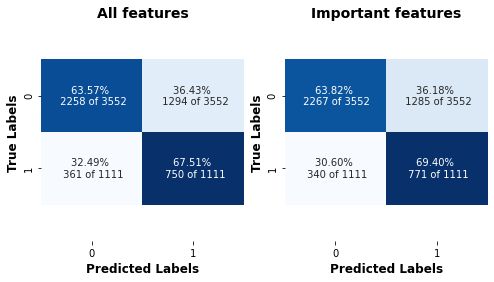

In [181]:
fig = plt.figure()
fig.set_size_inches(8, 4)
plot_confusion_matrix(stack_model, X_test, y_test, ax=fig.add_subplot(1,2,1), normalize=True, title='All features')
plot_confusion_matrix(stack_model1, X_test1, y_test1, ax=fig.add_subplot(1,2,2), normalize=True, title='Important features')
plt.savefig('temp.jpg')

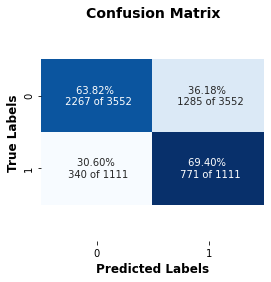

In [82]:
fig = plt.figure()
fig.set_size_inches(4, 4)
plot_confusion_matrix(stack_model1, X_test1, y_test1, ax=fig.add_subplot(1,1,1), normalize=True, title='Confusion Matrix')
plt.savefig('temp.jpg')

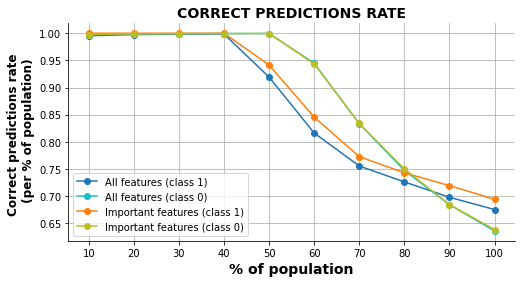

In [182]:
fig = plt.figure()
fig.set_size_inches(8, 4)
deciles = plot_cls_ratio_deciles([stack_model, stack_model1], [X_test, X_test1], [y_test, y_test1], [X_test.index, X_test1.index], 
                                 ax=fig.add_subplot(1,1,1), by_class=1, cumulative=True, title='CORRECT PREDICTIONS RATE',
                                 legend=['All features (class 1)', 'All features (class 0)',
                                         'Important features (class 1)', 'Important features (class 0)'])
plt.savefig('temp.jpg')

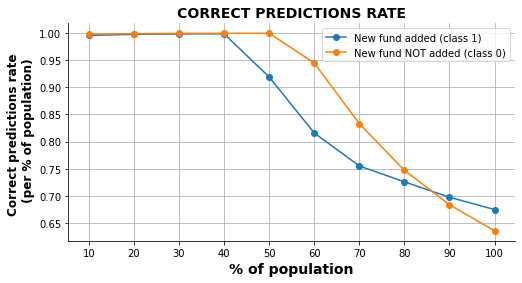

In [78]:
fig = plt.figure()
fig.set_size_inches(8, 4)
deciles = plot_cls_ratio_deciles([stack_model], [X_test], [y_test], [X_test.index], 
                                 ax=fig.add_subplot(1,1,1), by_class=1, cumulative=True, title='CORRECT PREDICTIONS RATE',
                                 legend=['New fund added (class 1)', 'New fund NOT added (class 0)'], colors=[['tab:blue', 'tab:orange']])
plt.savefig('temp.jpg')

### Results analysis

In [118]:
print(len(data_raw.loc[X_test1.index]), len(X_test1))

4663 4663


In [171]:
y1, total_mean, lift = get_lift_chart_proba(stack_model1, data_raw.loc[X_test1.index], X_test1, by_class=1)
print('Total population: ', len(X_test1))
print('Total mean: ', total_mean, '\n')
lift

Total population:  4663
Total mean:  0.4545819224827885 



,n_samples,dec_mean_proba,dec_lift_ovr_mean,n_cum_samples,cum_mean_proba,cum_lift_ovr_mean
0,466.0,0.776592,0.708365,466.0,0.776592,0.708365
1,466.0,0.656681,0.444583,932.0,0.716637,0.576474
2,466.0,0.592699,0.303833,1398.0,0.675324,0.485594
3,466.0,0.541863,0.192002,1864.0,0.641959,0.412196
4,466.0,0.495578,0.090184,2330.0,0.612683,0.347793
5,466.0,0.445186,-0.020670,2796.0,0.584766,0.286383
6,466.0,0.349816,-0.230466,3262.0,0.551202,0.212547
7,466.0,0.240975,-0.469898,3728.0,0.512424,0.127242
8,466.0,0.227583,-0.499357,4194.0,0.480775,0.057619
9,469.0,0.220355,-0.515258,4663.0,0.454582,0.000000


In [85]:
lift.to_csv('NewFund_cls_lift.csv')

In [183]:
y1.to_csv('NewFund_clc_test_data_deciles.csv')

In [179]:
important_cols

['pos_net_sales_12M',
 'neg_net_sales_12M',
 'new_Fund_added_12M',
 'no_of_sales_12M_1',
 'neg_net_no_of_funds_sold_12M_1',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'neg_net_sales_curr',
 'neg_net_no_of_fund_sales_12M_10K',
 'no_of_Redemption_12M_1',
 'pos_aum_P_CEF',
 'neg_aum_AC_MULTIPLE',
 'pos_net_no_of_fund_sales_12M_10K',
 'neg_aum_AC_FIXED_INCOME_TAXABLE',
 'neg_aum_AC_FIXED_INCOME_MUNI',
 'no_of_sales_12M_10K',
 'pos_aum_P_SMA',
 'neg_net_no_of_sales_12M_10K',
 'pos_net_no_of_assetclass_sold_12M_1',
 'pos_net_no_of_funds_sold_12M_1',
 'no_of_Redemption_12M_10K',
 'pos_aum_AC_TARGET',
 'pos_aum_AC_REAL_ESTATE',
 'redemption_curr',
 'pos_aum_P_UIT',
 'neg_net_no_of_assetclass_sold_12M_1',
 'pos_aum_AC_MULTIPLE',
 'sales_curr']

In [96]:
# # data1 = data_raw.copy()
# data1 = y1.copy()
# # data1['sales_12M_preds'] = stack_model1.predict_proba(data[X_test1.columns])
# p = stack_model1.predict_proba(data_raw[X_test1.columns])
# data1['proba_not_add_new_fund_2019'] = p[:,0]
# data1['proba_add_new_fund_2019'] = p[:,1]
# # data1['delta_sales_12M_18_preds'] = (data1['sales_12M_preds'] - data1['sales_12M'])

In [97]:
# data2 = data1.copy()

In [174]:
data2 = y1.copy()

In [98]:
data2 = data1.copy()
data2['aum_ac_sum'] = data2['aum_AC_FIXED_INCOME_TAXABLE'] + data2['aum_AC_FIXED_INCOME_MUNI'] + data2['aum_AC_TARGET'] + data2['aum_AC_REAL_ESTATE'] + data2['aum_AC_MULTIPLE'] + data2['aum_AC_PHYSICAL_COMMODITY']
data2['pos_ac_aum_sum'] = data2['pos_aum_AC_FIXED_INCOME_TAXABLE'] + data2['pos_aum_AC_EQUITY'] + data2['pos_aum_AC_TARGET'] + data2['pos_aum_AC_REAL_ESTATE'] + data2['pos_aum_AC_MULTIPLE'] + data2['pos_aum_AC_PHYSICAL_COMMODITY']
data2['neg_ac_aum_sum'] = data2['neg_aum_AC_FIXED_INCOME_TAXABLE'] + data2['neg_aum_AC_EQUITY'] + data2['neg_aum_AC_TARGET'] + data2['neg_aum_AC_REAL_ESTATE'] + data2['neg_aum_AC_MULTIPLE'] + data2['neg_aum_AC_PHYSICAL_COMMODITY']

In [99]:
# data2 = data_raw.copy()
data2['aum_p_sum'] = data2['aum_P_SMA'] + data2['aum_P_CEF'] + data2['aum_P_ETF'] + data2['aum_P_MF'] + data2['aum_P_UIT'] + data2['aum_P_529']
data2['pos_p_aum_sum'] = data2['pos_aum_P_SMA'] + data2['pos_aum_P_CEF'] + data2['pos_aum_P_ETF'] + data2['pos_aum_P_MF'] + data2['pos_aum_P_UIT'] + data2['pos_aum_P_529']
data2['neg_p_aum_sum'] = data2['neg_aum_P_SMA'] + data2['neg_aum_P_CEF'] + data2['neg_aum_P_ETF'] + data2['neg_aum_P_MF'] + data2['neg_aum_P_UIT'] + data2['neg_aum_P_529']

In [100]:
data2['aum_sum'] = data2['aum_ac_sum'] + data2['aum_p_sum']
data2['pos_aum_sum'] = data2['pos_ac_aum_sum'] + data2['pos_p_aum_sum']
data2['neg_aum_sum'] = data2['neg_ac_aum_sum'] + data2['neg_p_aum_sum']

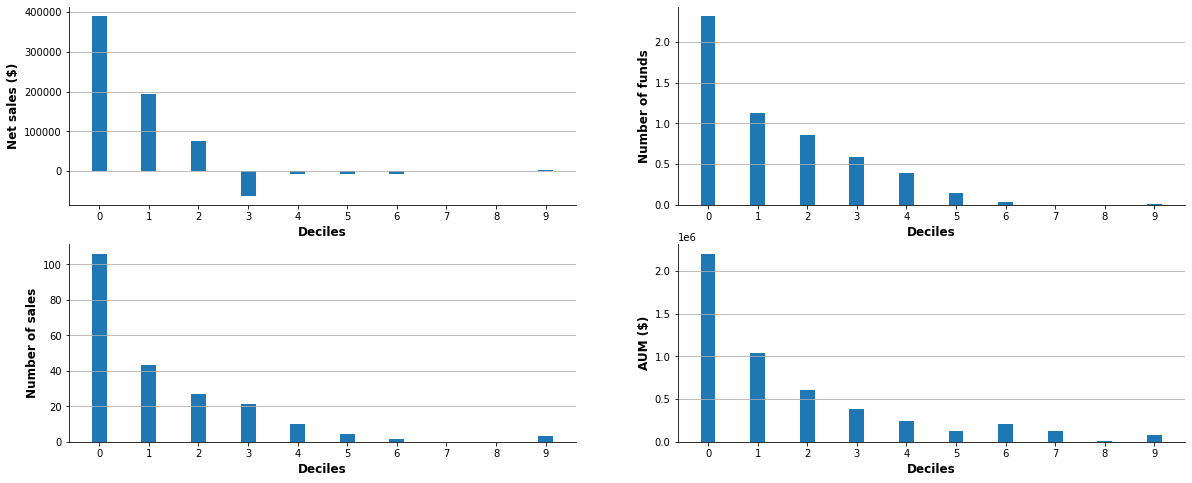

In [177]:
fig = plt.figure()
fig.set_size_inches(20, 8)

ax=fig.add_subplot(2,2,1)
plot_diagram_deciles(data2, y='net_sales_12M', ax=ax, y_title='Net sales ($)', title='')

ax=fig.add_subplot(2,2,2)
plot_diagram_deciles(data2, y='new_Fund_added_12M', ax=ax, y_title='Number of funds', title='')

ax=fig.add_subplot(2,2,3)
plot_diagram_deciles(data2, y='no_of_sales_12M_1', ax=ax, y_title='Number of sales', title='')

ax=fig.add_subplot(2,2,4)
plot_diagram_deciles(data2, y='pos_AUM', ax=ax, y_title='AUM ($)', title='')

# ax=fig.add_subplot(3,2,5)
# plot_diagram_xy(data2, x='pos_aum_AC_FIXED_INCOME_MUNI', y='sales_12M_target', ax=ax, x_title='Deciles: pos_aum_AC_FIXED_INCOME_MUNI per advisor', 
#                 y_title='Sales ($) target', title='', tick_labelsIprefix='$')

# ax=fig.add_subplot(3,2,6)
# plot_diagram_xy(data2, x='no_of_Redemption_12M_1', y='sales_12M_target', ax=ax, x_title='Deciles: no_of_Redemption_12M_1 per advisor', 
#                 y_title='Sales ($) target', title='', tick_labelsIprefix='$')

plt.savefig('temp.jpg')

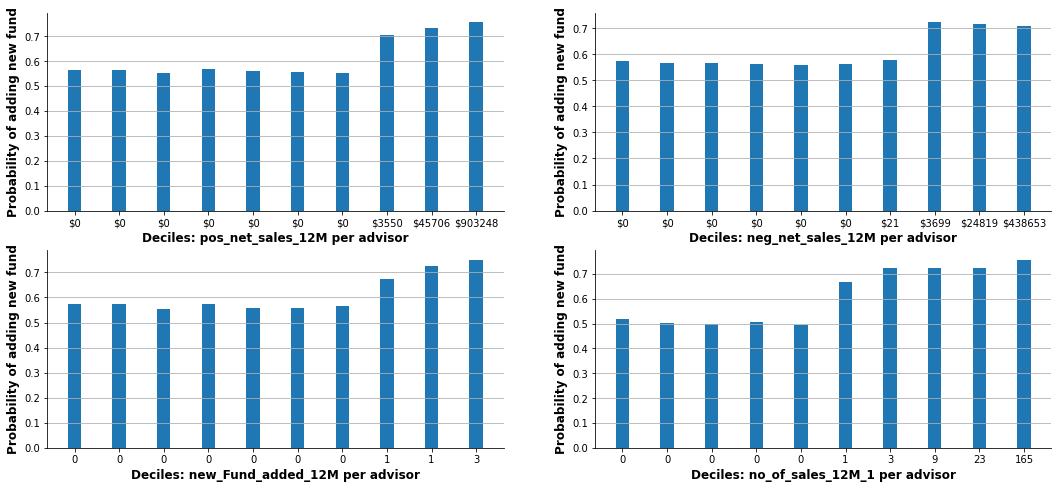

In [106]:
fig = plt.figure()
fig.set_size_inches(18, 8)

ax=fig.add_subplot(2,2,1)
plot_diagram_xy(data2, 
                x='pos_net_sales_12M', y='proba_add_new_fund_2019', ax=ax, x_title='Deciles: pos_net_sales_12M per advisor', 
                y_title='Probability of adding new fund', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(2,2,2)
plot_diagram_xy(data2, 
                x='neg_net_sales_12M', y='proba_add_new_fund_2019', ax=ax, x_title='Deciles: neg_net_sales_12M per advisor', 
                y_title='Probability of adding new fund', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(2,2,3)
plot_diagram_xy(data2, 
                x='new_Fund_added_12M', y='proba_add_new_fund_2019', ax=ax, x_title='Deciles: new_Fund_added_12M per advisor', 
                y_title='Probability of adding new fund', title='', tick_labelsIprefix='')

ax=fig.add_subplot(2,2,4)
plot_diagram_xy(data2, 
                x='no_of_sales_12M_1', y='proba_add_new_fund_2019', ax=ax, x_title='Deciles: no_of_sales_12M_1 per advisor', 
                y_title='Probability of adding new fund', title='', tick_labelsIprefix='')

plt.savefig('temp.jpg')

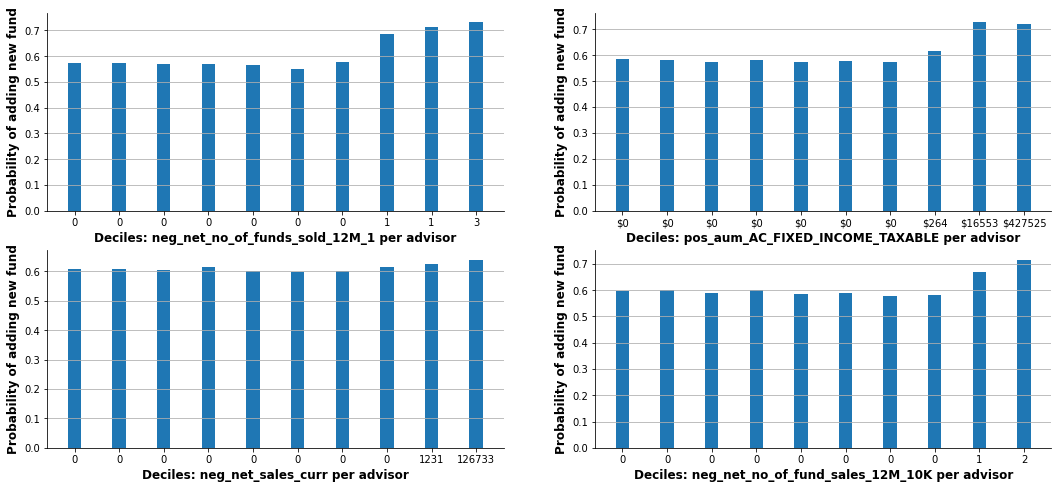

In [102]:
fig = plt.figure()
fig.set_size_inches(18, 8)

ax=fig.add_subplot(2,2,1)
plot_diagram_xy(data2, 
                x='neg_net_no_of_funds_sold_12M_1', y='proba_add_new_fund_2019', ax=ax, x_title='Deciles: neg_net_no_of_funds_sold_12M_1 per advisor', 
                y_title='Probability of adding new fund', title='', tick_labelsIprefix='')

ax=fig.add_subplot(2,2,2)
plot_diagram_xy(data2, 
                x='pos_aum_AC_FIXED_INCOME_TAXABLE', y='proba_add_new_fund_2019', ax=ax, x_title='Deciles: pos_aum_AC_FIXED_INCOME_TAXABLE per advisor', 
                y_title='Probability of adding new fund', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(2,2,3)
plot_diagram_xy(data2, 
                x='neg_net_sales_curr', y='proba_add_new_fund_2019', ax=ax, x_title='Deciles: neg_net_sales_curr per advisor', 
                y_title='Probability of adding new fund', title='', tick_labelsIprefix='')

ax=fig.add_subplot(2,2,4)
plot_diagram_xy(data2, 
                x='neg_net_no_of_fund_sales_12M_10K', y='proba_add_new_fund_2019', ax=ax, x_title='Deciles: neg_net_no_of_fund_sales_12M_10K per advisor', 
                y_title='Probability of adding new fund', title='', tick_labelsIprefix='')

plt.savefig('temp.jpg')

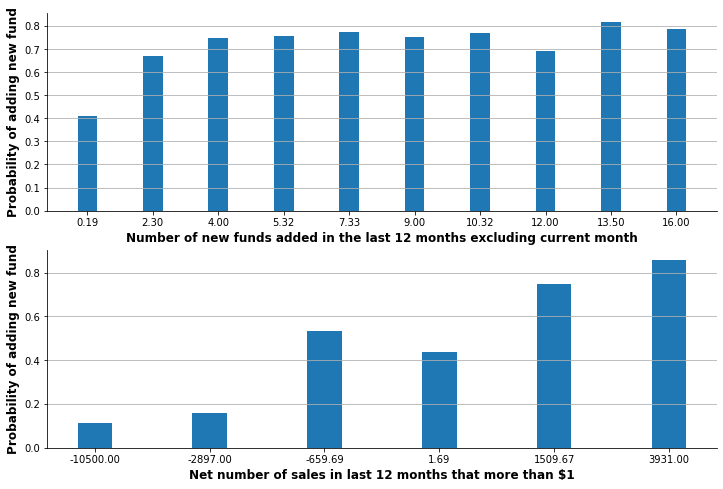

In [137]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax=fig.add_subplot(2,1,1)
plot_diagram_xy(data2, 
                x='new_Fund_added_12M', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Number of new funds added in the last 12 months excluding current month', 
                y_title='Probability of adding new fund', title='')

ax=fig.add_subplot(2,1,2)
plot_diagram_xy(data2, 
                x='net_no_of_sales_12M_1', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Net number of sales in last 12 months that more than $1', 
                y_title='Probability of adding new fund', title='')

plt.savefig('temp.jpg')

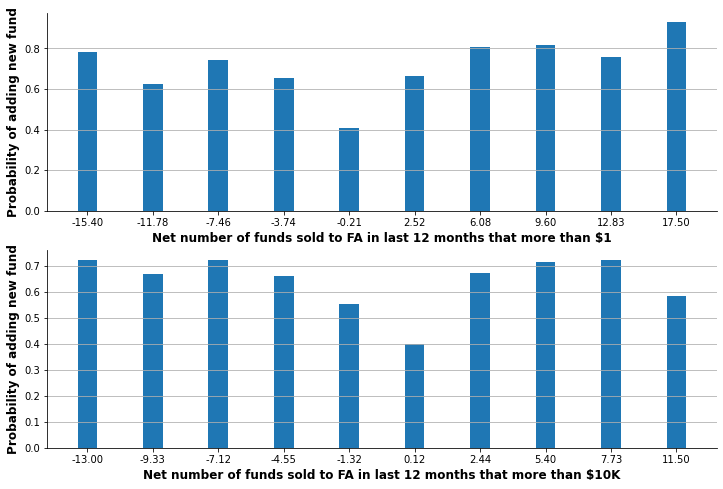

In [145]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax=fig.add_subplot(2,1,1)
plot_diagram_xy(data2, 
                x='net_no_of_funds_sold_12M_1', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Net number of funds sold to FA in last 12 months that more than $1', 
                y_title='Probability of adding new fund', title='')

ax=fig.add_subplot(2,1,2)
plot_diagram_xy(data2, 
                x='net_no_of_fund_sales_12M_10K', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Net number of funds sold to FA in last 12 months that more than $10K', 
                y_title='Probability of adding new fund', title='')

plt.savefig('temp.jpg')

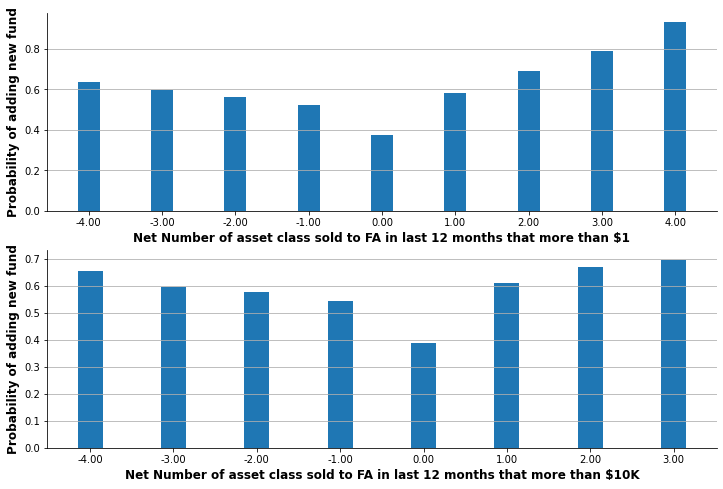

In [147]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax=fig.add_subplot(2,1,1)
plot_diagram_xy(data2, 
                x='net_no_of_assetclass_sold_12M_1', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Net Number of asset class sold to FA in last 12 months that more than $1', 
                y_title='Probability of adding new fund', title='')

ax=fig.add_subplot(2,1,2)
plot_diagram_xy(data2, 
                x='net_no_of_assetclass_sales_12M_10K', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Net Number of asset class sold to FA in last 12 months that more than $10K', 
                y_title='Probability of adding new fund', title='')

plt.savefig('temp.jpg')

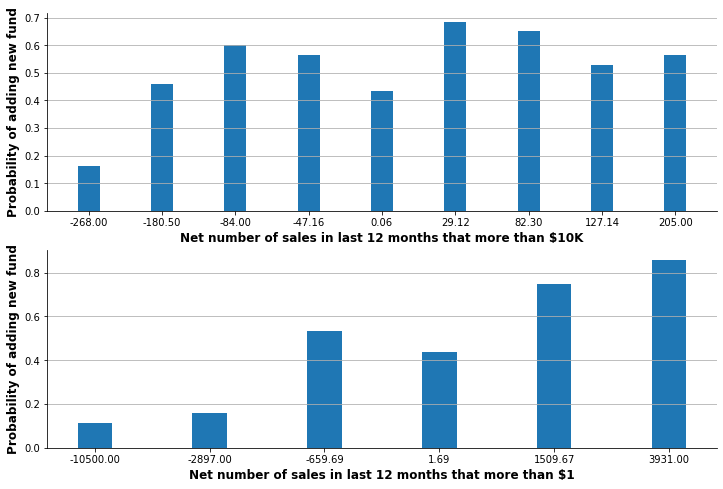

In [141]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax=fig.add_subplot(2,1,1)
plot_diagram_xy(data2, 
                x='net_no_of_sales_12M_10K', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Net number of sales in last 12 months that more than $10K', 
                y_title='Probability of adding new fund', title='')

ax=fig.add_subplot(2,1,2)
plot_diagram_xy(data2, 
                x='net_no_of_sales_12M_1', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Net number of sales in last 12 months that more than $1', 
                y_title='Probability of adding new fund', title='')

plt.savefig('temp.jpg')

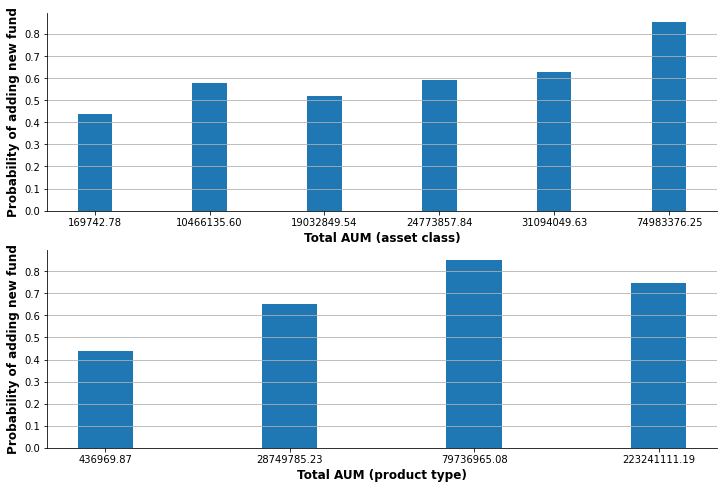

In [148]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax=fig.add_subplot(2,1,1)
plot_diagram_xy(data2, 
                x='pos_ac_aum_sum', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Total AUM (asset class)', 
                y_title='Probability of adding new fund', title='')

ax=fig.add_subplot(2,1,2)
plot_diagram_xy(data2, 
                x='pos_p_aum_sum', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Total AUM (product type)', 
                y_title='Probability of adding new fund', title='')

plt.savefig('temp.jpg')

#### Conclusions

1. Advisors with higher total sales in current month have slightly higher probability of adding new fund in next 12 months.
2. Advisors that have smaller number of sales that more than \\$1 in the last 12 months are more likely to add a new fund in next year.
3. Advisors who added more funds in the last 12 months are likely to add a new fund in next year. However, those advisors who have highest number of funds added in the last 12 months are less probable to add a new fund in next year.
4. Advisors with higher total AUM in asset class MULTIPLE, FIXED INCOME TAXABLE, TARGET and REAL ESTATE have less probability of adding new fund in next 12 months. However, advisors with higher total AUM in product class UIT and MF have higher probability of adding new fund in next 12 months.